# Unit Convention for Developer
Tianzhe Zhou 2024/11/1

To set up a solid foundation for the development of the project, 
we need to establish a unit convention for the project. 
The unit convention is a set of rules that define the units of the physical quantities used in the project. 
The unit convention is important because it ensures that all developers use the same units for the same physical quantities, which helps to avoid errors and inconsistencies throughout the whole project.

In [1]:
fm = 1
hbarc = 0.197327053
c = 1  # speed of light
hbar = 1  # reduced Planck constant

GeV = 1 / hbarc  # Giga-electronvolt
MeV = 1e-3 * GeV  # Mega-electronvolt

g = 5.625e26 * MeV  # gram
kg = 1e3 * g  # kilogram
cm = 1e13 * fm  # centimeter
m = 100 * cm  # meter
km = 1e5 * cm  # kilometer
s = 3e10 * cm  # second

dyn = g * cm / s**2  # dyne
dyn_cm_2 = dyn / cm**2  # dyne / cm^2
g_cm_3 = g / cm**3  # gram / cm^3
erg = dyn * cm  # ἐργον energy unit

m_n = 939.565 * MeV  # mass of neutron
n0 = 0.16 / fm**3  # saturation density

e0 = m_n * n0  # saturation energy density
G = 6.6743e-8 * dyn * cm**2 / g**2  # gravitational constant
Msun = 1.989e33 * g  # mass of sun


The first 4 lines come from a widely used unit convention in High Energy Physics (HEP),
which is called [Natural Unit System](https://en.wikipedia.org/wiki/Natural_units).
You should be awared that we will NEVER using the Natural Unit System explicity,
as long as you obey the following rules.
1. Whenever you define a [literal](https://www.ituonline.com/tech-definitions/what-is-literal-programming/) 
physical quantity, you should always *multiply* the unit of that quantity.
```python
# example of rule 1:
m_n = 939.565 * MeV  # GOOD
m_n = 939.565        # BAD
m_n = 1.67e-27 * kg  # GOOD
```

2. Whenever you want a physical quantity in cgs unit(or others unit system), 
you should always *divide* the corresponding unit.

In [2]:
# example of rule 2:
m_n = 939.565 * MeV  # mass of neutron
# if I want to know m_n in terms of gram, I need to
print(m_n / g)

1.670337777777778e-24


3. When you need to plot, *devide* the unit of your axis. See the example below.

4. When you use physic formula, you leave the whole form as it was, no additional constants.
```python
# example of rule 4:
E = m * c**2     # GOOD
F = G*M*m / r**2 # GOOD
```

Now we present a full procedure of how to use the unit convention in calculating MR relation.
See https://arxiv.org/pdf/astro-ph/0506417v1 Page 15 for more details.

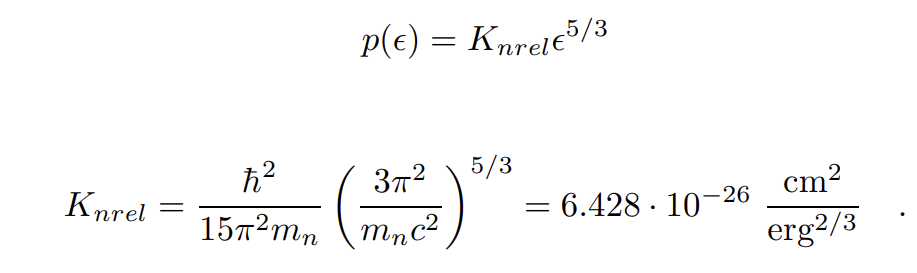

In [3]:
import numpy as np
from numpy import pi

K_nrel = hbar**2 / (15 * pi**2 * m_n) * (3 * pi**2 / (m_n * c**2)) ** (5 / 3)  # Rule 1
print(K_nrel / (cm**2 / erg ** (2 / 3)))  # Rule 2

6.433772787333139e-26


In [4]:
def EOS_P(e):
    return K_nrel * e ** (5 / 3)  # Rule 4


e_min = 1e4 * g_cm_3  # Rule 1
e_max = 1e18 * g_cm_3  # Rule 1
e_grid = np.geomspace(e_min, e_max, 10000)
p_grid = EOS_P(e_grid)


def EofP(P, e_grid, p_grid):
    return np.interp(P, p_grid, e_grid)


def PofE(E, e_grid, p_grid):
    return np.interp(E, e_grid, p_grid)

In [5]:
from scipy.integrate import ode


# working with rescaled quantities
def TOV1(r, y, grids):
    p, m = y
    e_grid = grids[0]
    p_grid = grids[1]

    e = EofP(p, e_grid, p_grid)

    dpdr = -(e + p) * (m + 4 * pi * r**3 * p)  # Rule 4
    dpdr = dpdr / (r * (r - 2 * m))  # Rule 4
    dmdr = 4 * pi * r**2 * e  # Rule 4

    return np.array([dpdr, dmdr])


def solveTOV1(rho_c, e_grid, p_grid):
    # Notice that we only rescale quantities inside this function
    rho_c = rho_c * G / c**2
    e_grid = e_grid * G / c**2
    p_grid = p_grid * G / c**4

    Pmin = p_grid[0]

    r = 4.441e-16 * cm  # Rule 1
    dr = 10.0 * cm  # Rule 1

    p_c = PofE(rho_c, e_grid, p_grid)

    P0 = p_c - (4 * pi / 3) * (p_c + rho_c) * (3 * p_c + rho_c) * r**2  # Rule 4
    m0 = 4 / 3 * pi * rho_c * r**3  # Rule 4

    param = (e_grid, p_grid)

    stateTOV = np.array((P0, m0))
    sy = ode(TOV1).set_integrator("dop853")
    sy.set_initial_value(stateTOV, r).set_f_params(param)
    while sy.successful() and stateTOV[0] > Pmin:
        stateTOV = sy.integrate(sy.t + dr)
        dpdr, dmdr = TOV1(sy.t + dr, stateTOV, param)
        dr = 0.46 / (dmdr / stateTOV[1] - dpdr / stateTOV[0])
    # at the end of this function, we rescale the quantities back
    return stateTOV[1] * c**2 / G, sy.t


def compute_tov_properties(rho_c, e_grid, p_grid):
    M = np.zeros_like(rho_c)
    R = np.zeros_like(rho_c)
    for i in range(len(rho_c)):
        M[i], R[i] = solveTOV1(rho_c[i], e_grid, p_grid)
    return M, R


def cal_MR():
    density = np.geomspace(1e14 * g_cm_3, e_max, 100)  # Rule 1
    return compute_tov_properties(density, e_grid, p_grid)

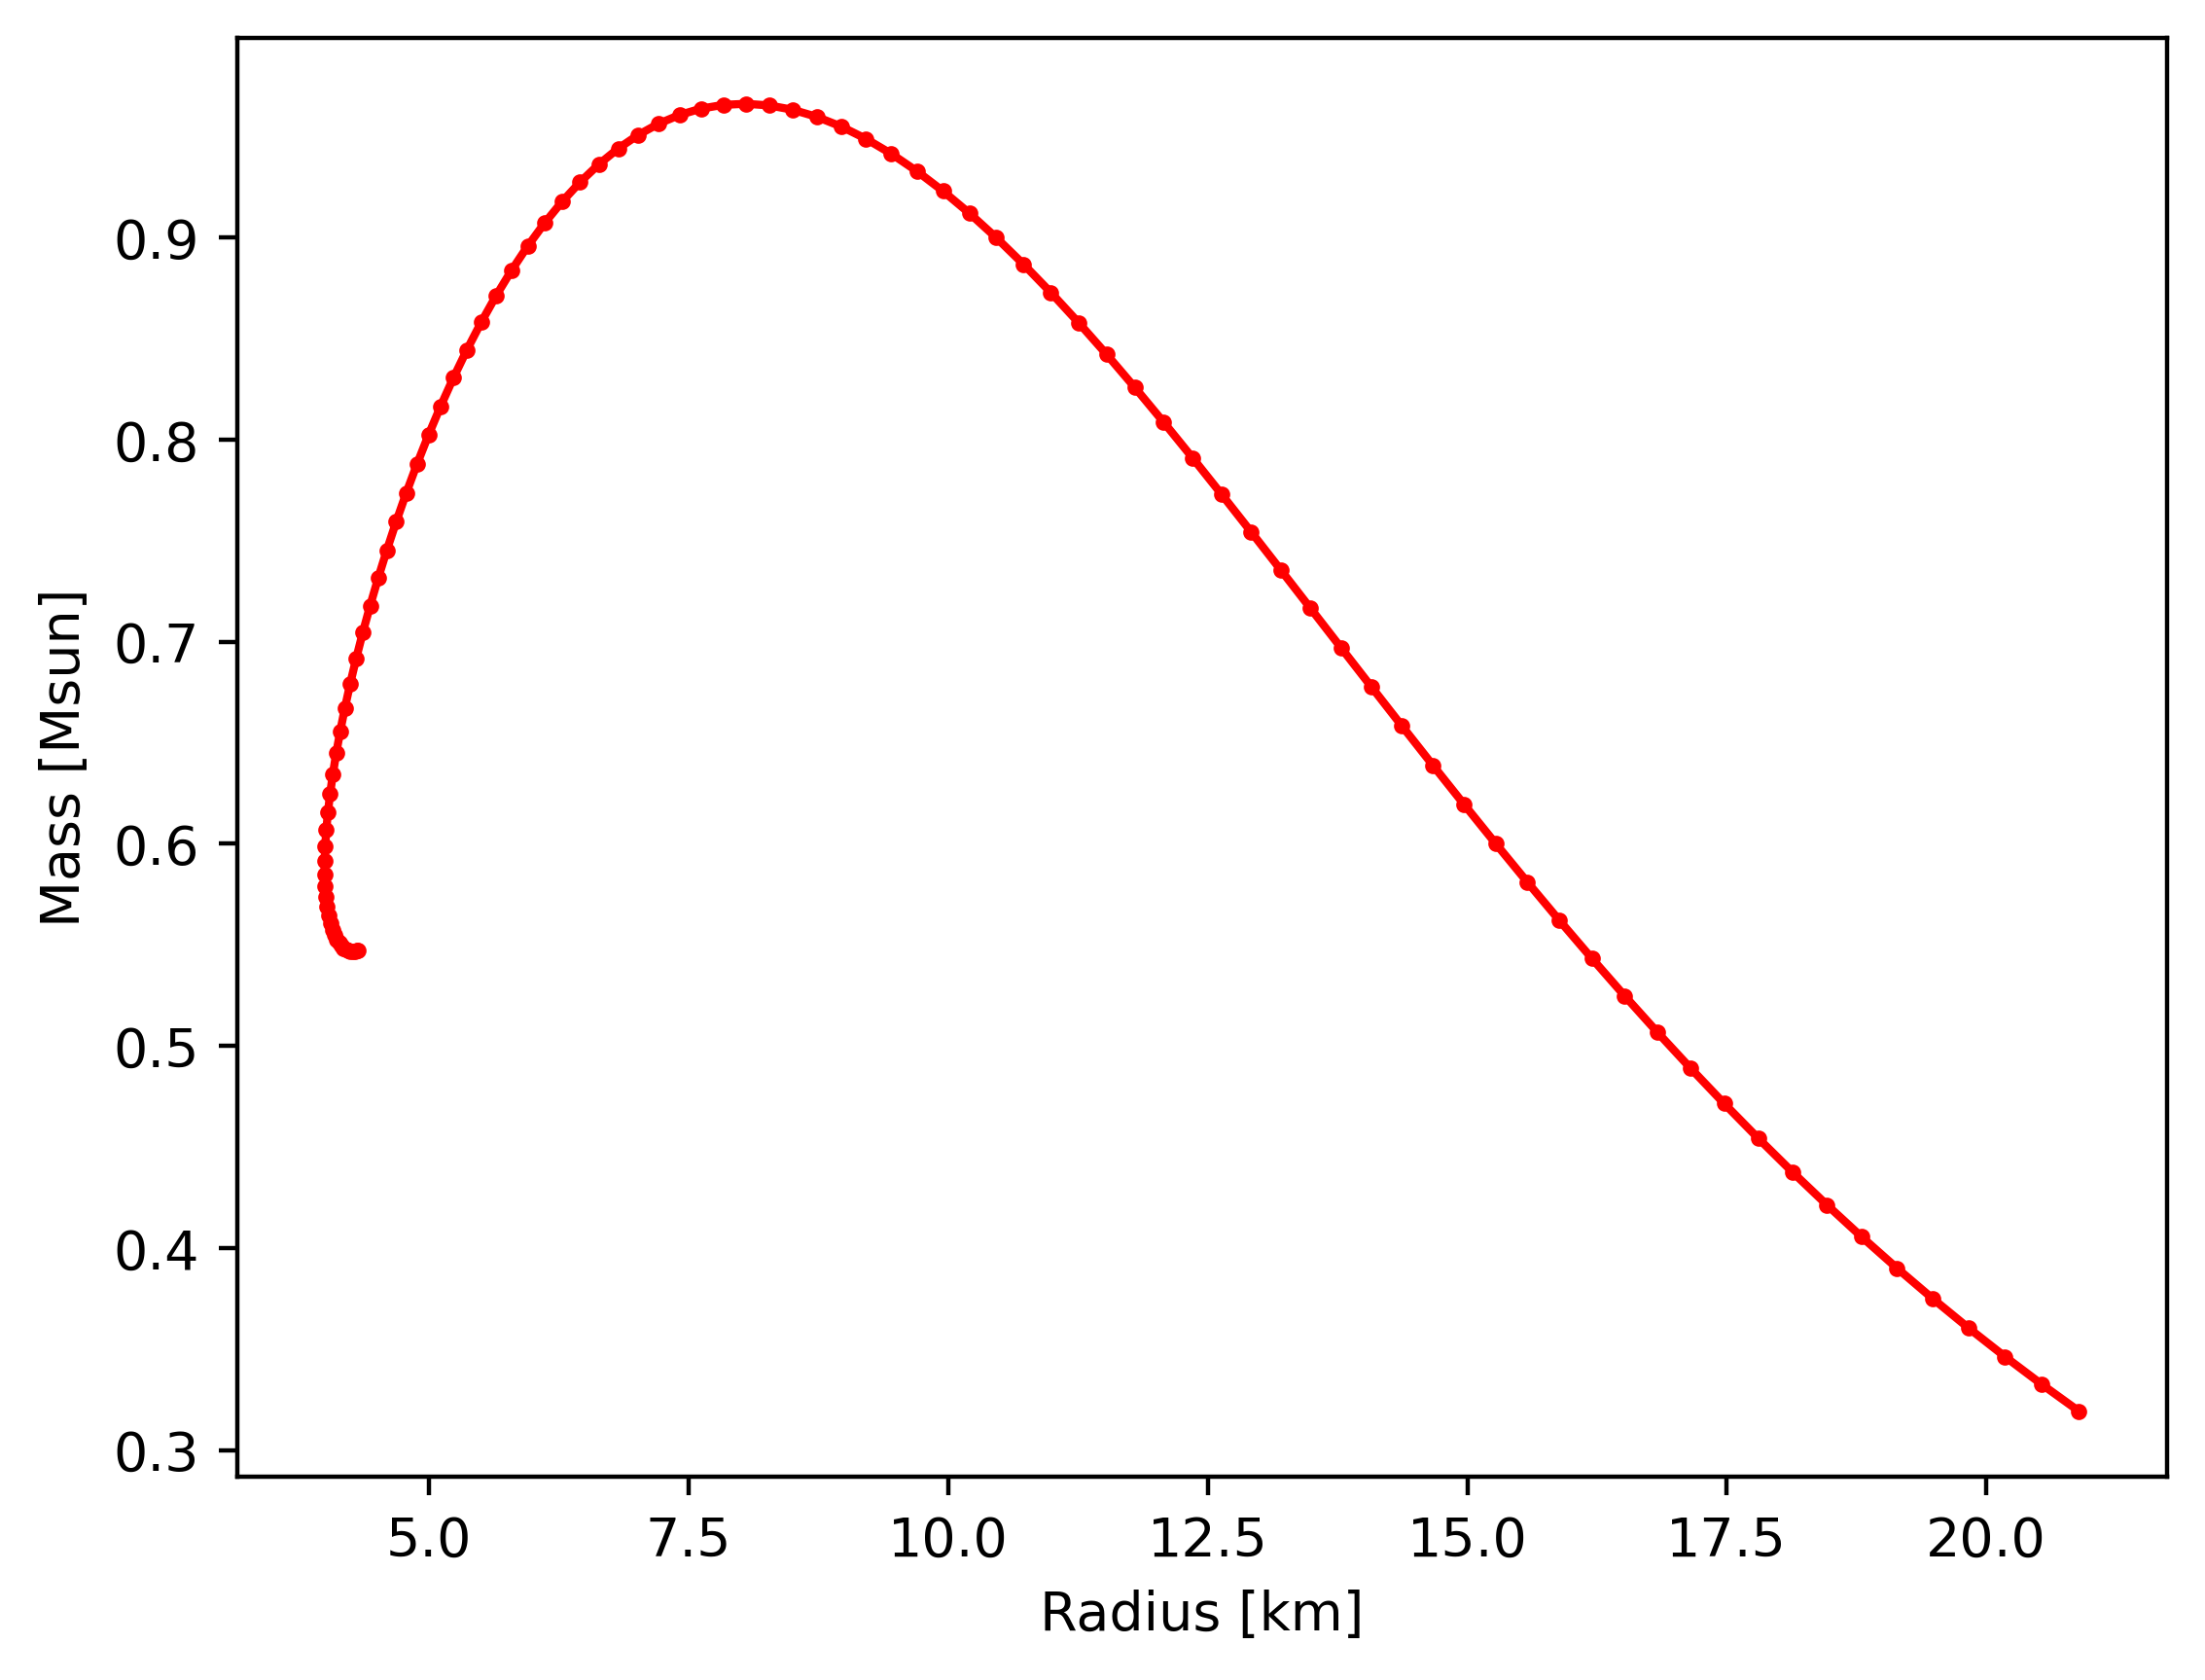

In [6]:
import matplotlib.pyplot as plt

M, R = cal_MR()

plt.figure(dpi=400)
plt.plot(R / km, M / Msun, "ro-", ms=2)  # Rule 3
plt.xlabel("Radius [km]")
plt.ylabel("Mass [Msun]")
plt.show()